<a href="https://colab.research.google.com/github/Thinsheep/TrainingTrack/blob/main/Behavior_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Thinsheep/TrainingTrack

Cloning into 'TrainingTrack'...
remote: Enumerating objects: 15835, done.
remote: Counting objects: 100% (15835/15835), done.
remote: Compressing objects: 100% (15835/15835), done.
remote: Total 15835 (delta 0), reused 15835 (delta 0), pack-reused 0
Receiving objects: 100% (15835/15835), 202.43 MiB | 19.11 MiB/s, done.
Checking out files: 100% (15835/15835), done.


In [ ]:
!ls TrainingTrack

driving_log.csv  IMG


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath # to working with the path
import random

In [ ]:
datadir = 'TrainingTrack'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1) # to solve display overlapping
data.head() # to view the first five line of the frame

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\User\Desktop\TrainingData\IMG\center_2020_11_28_07_38_13_000.jpg,C:\Users\User\Desktop\TrainingData\IMG\left_2020_11_28_07_38_13_000.jpg,C:\Users\User\Desktop\TrainingData\IMG\right_2020_11_28_07_38_13_000.jpg,0.0,0.0,0.0,19.68481
1,C:\Users\User\Desktop\TrainingData\IMG\center_2020_11_28_07_38_13_070.jpg,C:\Users\User\Desktop\TrainingData\IMG\left_2020_11_28_07_38_13_070.jpg,C:\Users\User\Desktop\TrainingData\IMG\right_2020_11_28_07_38_13_070.jpg,0.0,0.0,0.0,19.52651
2,C:\Users\User\Desktop\TrainingData\IMG\center_2020_11_28_07_38_13_137.jpg,C:\Users\User\Desktop\TrainingData\IMG\left_2020_11_28_07_38_13_137.jpg,C:\Users\User\Desktop\TrainingData\IMG\right_2020_11_28_07_38_13_137.jpg,0.0,0.0,0.0,19.40860
3,C:\Users\User\Desktop\TrainingData\IMG\center_2020_11_28_07_38_13_210.jpg,C:\Users\User\Desktop\TrainingData\IMG\left_2020_11_28_07_38_13_210.jpg,C:\Users\User\Desktop\TrainingData\IMG\right_2020_11_28_07_38_13_210.jpg,0.0,0.0,0.0,19.25250
4,C:\Users\User\Desktop\TrainingData\IMG\center_2020_11_28_07_38_13_277.jpg,C:\Users\User\Desktop\TrainingData\IMG\left_2020_11_28_07_38_13_277.jpg,C:\Users\User\Desktop\TrainingData\IMG\right_2020_11_28_07_38_13_277.jpg,0.0,0.0,0.0,19.13633


In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf) # we only show the tail of the link
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2020_11_28_07_38_13_000.jpg,left_2020_11_28_07_38_13_000.jpg,right_2020_11_28_07_38_13_000.jpg,0.0,0.0,0.0,19.68481
1,center_2020_11_28_07_38_13_070.jpg,left_2020_11_28_07_38_13_070.jpg,right_2020_11_28_07_38_13_070.jpg,0.0,0.0,0.0,19.52651
2,center_2020_11_28_07_38_13_137.jpg,left_2020_11_28_07_38_13_137.jpg,right_2020_11_28_07_38_13_137.jpg,0.0,0.0,0.0,19.40860
3,center_2020_11_28_07_38_13_210.jpg,left_2020_11_28_07_38_13_210.jpg,right_2020_11_28_07_38_13_210.jpg,0.0,0.0,0.0,19.25250
4,center_2020_11_28_07_38_13_277.jpg,left_2020_11_28_07_38_13_277.jpg,right_2020_11_28_07_38_13_277.jpg,0.0,0.0,0.0,19.13633


[  99    9    1   25   22   26   33   35   65   70   34   68 4247   90
   41   81   80   37   60   22   37   18    8   13   57]
[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


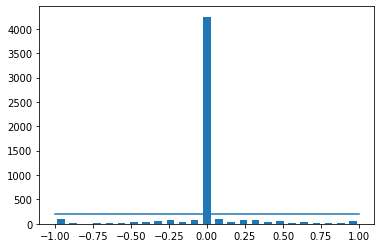

In [ ]:
num_bins = 25 
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
#hist assigned to veritcal values and bins to horizontal values.
center = (bins[:-1] + bins[1:])*0.5
# we plus togther so it can cancel each other and become center value
# -0.92 + 0.92, -0.04 + 0.04, then it become double we need *0.5 to get back
print(hist)
print(bins)
plt.bar(center, hist, width= 0.05)
# the vertical axis is the frequency of steering, we most at the time in the 
# middle of the track
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
# we reject all samples that exceed 200, in this case is 0

total date 5278
removed 4047
remaining: 1231


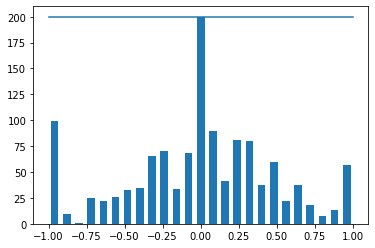

In [ ]:
print('total date', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i]<= bins[j+1]:
      list_.append(i)
    # we try to combine neigbor values to the same bins, for example -0.97, -0.95
  list_ = shuffle(list_)# make sure equally cut data from begining to the end of track
  list_ = list_[samples_per_bin: ] # we cut from 200 to the end of the list
  remove_list.extend(list_)

print('removed', len(remove_list))
data.drop(data.index[remove_list], inplace= True)
# inplace is to have all updated value remain on the same copy
# mean removing the gap when serveral steering positions are removed. 
print('remaining:', len(data))
    
hist, _ =np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width= 0.05)
# the vertical axis is the frequency of steering, we most at the time in the 
# middle of the track
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
# we reject all samples that exceed 200, in this case is 0

In [ ]:
# our data seem not to be well balance but we take care of it later.
# now we split the training and validation data
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    #.strip help to remove all the space in the link
    steering.append(float(indexed_data[3]))
    # the position of steering is position 3 in the data.iloc
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
  
image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2020_11_28_07_38_14_256.jpg
left        left_2020_11_28_07_38_14_256.jpg  
right       right_2020_11_28_07_38_14_256.jpg 
steering    0.15                              
throttle    0                                 
reverse     0                                 
speed       17.0234                           
Name: 18, dtype: object


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size =0.2, random_state=6)
# random_state, random the way data split 
print('Training samples:{} \n Valid sample {} '.format(len(X_train), len(X_valid)))

Training samples:984 
 Valid sample 247 


Text(0.5, 1.0, 'Validation_set')

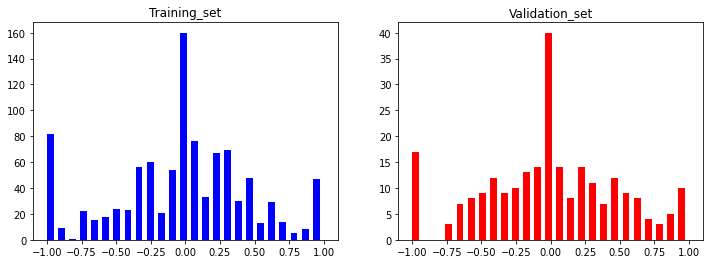

In [ ]:
# Now make sure both dataset include uniform distribution dataset.
fig, axs = plt.subplots(1, 2, figsize =(12,4))
axs[0].hist(y_train, bins=num_bins, width=0.05, color ='blue')
axs[0].set_title('Training_set')
axs[1].hist(y_valid, bins=num_bins, width=0.05, color ='red')
axs[1].set_title('Validation_set')

In [ ]:
# our image currently just the link to the image so we use mpimg
# to use the real images
def img_preprocess1(img):
  img = mpimg.imread(img)
  return img

Text(0.5, 1.0, 'Preprocessed_Image')

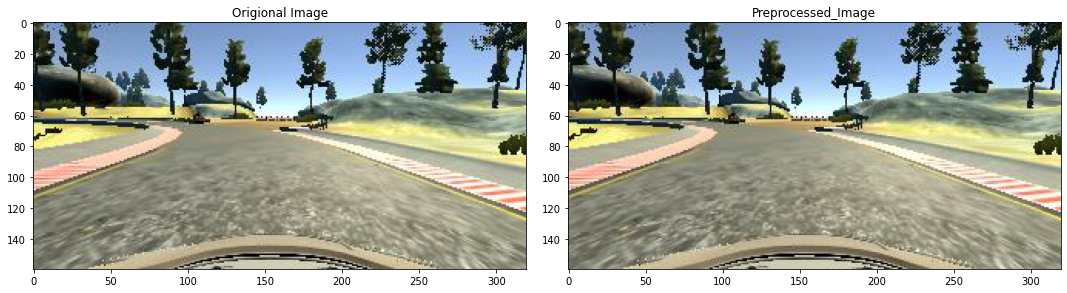

In [ ]:
image = image_paths[100] # take the image at position 100
origional_image = mpimg.imread(image)
preprocessed_image = img_preprocess1(image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(origional_image)
axs[0].set_title('Origional Image')
axs[1].imshow(origional_image)
axs[1].set_title('Preprocessed_Image')

In [ ]:
# we can see there some areas not support for our training for example front part of 
# the car, or the sky now we try tro crop them
def img_preprocess2(img):
  img = mpimg.imread(img)
  img = img[60:135, :, :]
  return img

Text(0.5, 1.0, 'Preprocessed_Image')

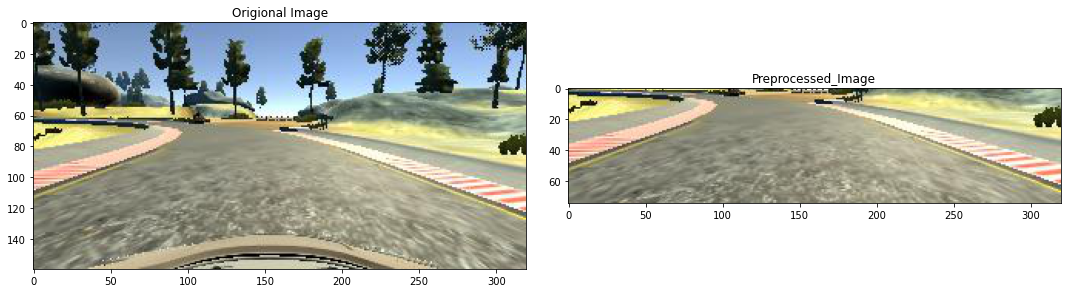

In [ ]:
image = image_paths[100] # take the image at position 100
origional_image = mpimg.imread(image)
preprocessed_image = img_preprocess2(image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(origional_image)
axs[0].set_title('Origional Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed_Image')

In [ ]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135, :, :]
  # there are many model but we will use NVIDIA model, then we need to convert
  # the color of img to YUV, this color very effective in training NVDA model
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66)) # resize allow for fast computation and eaiser to work with
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed_Image')

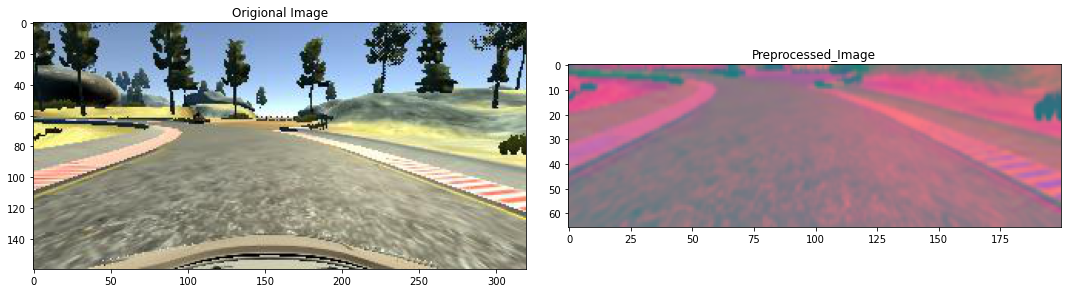

In [ ]:
image = image_paths[100] # take the image at position 100
origional_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(origional_image)
axs[0].set_title('Origional Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed_Image')

In [ ]:
#del list # somehow list defined but it is built in function, we need to delete the define
X_train = np.array(list(map(img_preprocess, X_train))) # format the list into array
# now we successful to preprocess our entire dataset
X_valid = np.array(list(map(img_preprocess, X_valid)))

(984, 66, 200, 3)


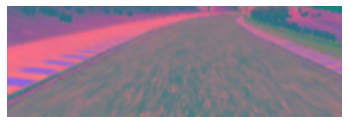

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train) -1)])
plt.axis('off')
print(X_train.shape)

In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='elu'))
  # because we subsampling 1 pixel at the time, now we use 2x2 
  # to make it quicker. it contains 66x200xU-V images, these images normalize in architecht.
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Dropout(0.5)) # this is not from NVIDEA
  
  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5)) # this is not from NVIDEA

  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(1))
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer = optimizer)
  # now we make sure the modle not overfit our training data
  return model

In [ ]:
model = nvidia_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 18, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0

In [ ]:
history = model.fit(X_train, y_train, epochs=30, validation_data= (X_valid, y_valid), batch_size=100, verbose=1, shuffle=1)
# batch_size =100 because our dataset only 1010 images


Epoch 1/30
10/10 [==============================] - 7s 653ms/step - loss: 1.5401 - val_loss: 0.2266
Epoch 2/30
10/10 [==============================] - 7s 665ms/step - loss: 0.4842 - val_loss: 0.2624
Epoch 3/30
10/10 [==============================] - 7s 667ms/step - loss: 0.3196 - val_loss: 0.2181
Epoch 4/30
10/10 [==============================] - 6s 647ms/step - loss: 0.2776 - val_loss: 0.2229
Epoch 5/30
10/10 [==============================] - 6s 629ms/step - loss: 0.2423 - val_loss: 0.2141
Epoch 6/30
10/10 [==============================] - 6s 625ms/step - loss: 0.2493 - val_loss: 0.2132
Epoch 7/30
10/10 [==============================] - 6s 623ms/step - loss: 0.2512 - val_loss: 0.2149
Epoch 8/30
10/10 [==============================] - 6s 626ms/step - loss: 0.2433 - val_loss: 0.2049
Epoch 9/30
10/10 [==============================] - 7s 667ms/step - loss: 0.2284 - val_loss: 0.2040
Epoch 10/30
10/10 [==============================] - 8s 848ms/step - loss: 0.2317 - val_loss: 0.1997

Text(0.5, 0, 'Epoch')

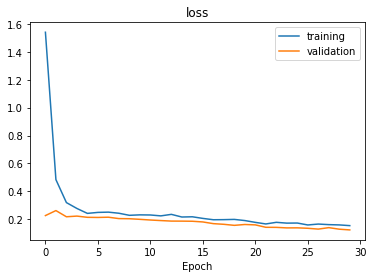

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('Epoch')

In [ ]:
model.save('model.h5') # save and download our model.

In [ ]:
from google.colab import files
files.download('model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>